# DBScan training with Sagemaker Scikit-learn
Run through a dbscan sample scenario accodring to the page

https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html

In [1]:
# S3 prefix
prefix = 'Scikit-dbscan-test'

import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

## Upload the data for training <a class="anchor" id="upload_data"></a>


In [14]:
import numpy as np
import os
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)

# #############################################################################

# Create directory and write csv
os.makedirs('./data', exist_ok=True)
np.savetxt('./data/train_data.csv', X, delimiter=',')
np.savetxt('./data/true_data.csv', labels_true, delimiter=',')

Once we have the data locally, we can use use the tools provided by the SageMaker Python SDK to upload the data to a default bucket. 

In [15]:
WORK_DIRECTORY = 'data'

train_input = sagemaker_session.upload_data(WORK_DIRECTORY, key_prefix="{}/{}".format(prefix, WORK_DIRECTORY) )

## Create a Scikit-learn script to train with <a class="anchor" id="create_sklearn_script"></a>
SageMaker can now run a scikit-learn script using the `SKLearn` estimator. When executed on SageMaker a number of helpful environment variables are available to access properties of the training environment, such as:

* `SM_MODEL_DIR`: A string representing the path to the directory to write model artifacts to. Any artifacts saved in this folder are uploaded to S3 for model hosting after the training job completes.
* `SM_OUTPUT_DIR`: A string representing the filesystem path to write output artifacts to. Output artifacts may include checkpoints, graphs, and other files to save, not including model artifacts. These artifacts are compressed and uploaded to S3 to the same S3 prefix as the model artifacts.

Supposing two input channels, 'train' and 'test', were used in the call to the `SKLearn` estimator's `fit()` method, the following environment variables will be set, following the format `SM_CHANNEL_[channel_name]`:

* `SM_CHANNEL_TRAIN`: A string representing the path to the directory containing data in the 'train' channel
* `SM_CHANNEL_TEST`: Same as above, but for the 'test' channel.

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an `argparse.ArgumentParser` instance. 

Because the Scikit-learn container imports your training script, you should always put your training code in a main guard `(if __name__=='__main__':)` so that the container does not inadvertently run your training code at the wrong point in execution.

For more information about training environment variables, please visit https://github.com/aws/sagemaker-containers.

## Create SageMaker Scikit Estimator <a class="anchor" id="create_sklearn_estimator"></a>

To run our Scikit-learn training script on SageMaker, we construct a `sagemaker.sklearn.estimator.sklearn` estimator, which accepts several constructor arguments:

* __entry_point__: The path to the Python script SageMaker runs for training and prediction.
* __role__: Role ARN
* __train_instance_type__ *(optional)*: The type of SageMaker instances for training. __Note__: Because Scikit-learn does not natively support GPU training, Sagemaker Scikit-learn does not currently support training on GPU instance types.
* __sagemaker_session__ *(optional)*: The session used to train on Sagemaker.
* __hyperparameters__ *(optional)*: A dictionary passed to the train function as hyperparameters.

To see the code for the SKLearn Estimator, see here: https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/sklearn

In [16]:
from sagemaker.sklearn.estimator import SKLearn

script_path = 'dbscan_test.py'

sklearn = SKLearn(
    entry_point=script_path,
    train_instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session,
    hyperparameters={'eps': 0.3, 'min_samples': 10})

In [17]:
!cat dbscan_test.py

from __future__ import print_function

import argparse
import os

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.datasets.samples_generator import make_blobs

if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Hyperparameters are described here. In this simple example we are just including one hyperparameter.
    parser.add_argument('--eps', type=float, default=0.3)
    parser.add_argument('--min_samples', type=int, default=10)

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    parser.add_argument('--output-data-dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])

    args = parser.parse_args()

    # Take the file and read it into a numpy array
    input_file = os.path.

## Train SKLearn Estimator  <a class="anchor" id="train_sklearn"></a>
Training is very simple, just call `fit` on the Estimator! This will start a SageMaker Training job that will download the data for us, invoke our scikit-learn code (in the provided script file), and save any model artifacts that the script creates.

In [18]:
sklearn.fit({'train': train_input})

INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2019-03-09-14-19-32-113


2019-03-09 14:19:32 Starting - Starting the training job...
2019-03-09 14:19:36 Starting - Launching requested ML instances......
2019-03-09 14:20:42 Starting - Preparing the instances for training......
2019-03-09 14:22:00 Downloading - Downloading input data
2019-03-09 14:22:00 Training - Training image download completed. Training in progress.
2019-03-09 14:22:00 Uploading - Uploading generated training model
2019-03-09 14:22:00 Completed - Training job completed

2019-03-09 14:21:48,875 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2019-03-09 14:21:48,878 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-03-09 14:21:48,893 sagemaker_sklearn_container.training INFO     Invoking user training script.
2019-03-09 14:21:49,212 sagemaker-containers INFO     Module dbscan_test does not provide a setup.py. 
Generating setup.py
2019-03-09 14:21:49,212 sagemaker-containers INFO     Generating setup.cfg
2019-03-09 14:21:4

## Get the result from S3 and plot it 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DBSCAN from version 0.20.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


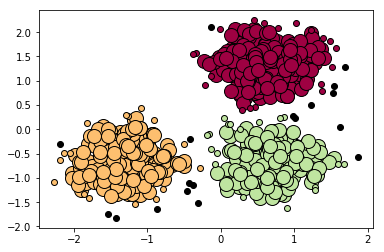

In [19]:
import boto3
import tarfile
from sklearn.externals import joblib

s3 = boto3.resource('s3')
model_path = sklearn.model_data
bucket_name = model_path.split('/')[2]
key = model_path.split(bucket_name)[1][1:]
s3.Object(bucket_name, key).download_file('model.tar.gz')

with tarfile.open('model.tar.gz', 'r:gz') as tf:
    tf.extractall()

db = joblib.load('model.joblib')
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.show()